In [1]:
library(parallel)
library(pdist)
library(ggplot2)
library(cowplot)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
fx_CHAOS = function(clusterlabel, location){
  # require(parallel)
  matched_location=location
  NAs = which(is.na(clusterlabel))
  if(length(NAs>0)){
    clusterlabel=clusterlabel[-NAs]
    matched_location = matched_location[-NAs,]
  }
  matched_location = scale(matched_location)
  dist_val = rep(0,length(unique(clusterlabel)))
  count = 0
  for(k in unique(clusterlabel)){
    count = count + 1
    location_cluster = matched_location[which(clusterlabel == k),]
    if(length(location_cluster)==2){next}
    #require(parallel)
    results = mclapply(1:dim(location_cluster)[1], fx_1NN, location_in=location_cluster, mc.cores = 5)
    dist_val[count] = sum(unlist(results))
  }
  dist_val = na.omit(dist_val)
  return(sum(dist_val)/length(clusterlabel))

}


In [3]:
#' @import pdist
fx_1NN = function(i,location_in){
  # library(pdist)
  line_i = rep(0,dim(location_in)[1])
  line_i = pdist(location_in[i,],location_in[-i,])@dist
  return(min(line_i))
}

In [4]:
dataset_list <- c('E12_5_rep1', 'E13_5_rep2', 'E15_5_rep1')
method_list <- c('nnSVG', 'Spanve', 'SPARK-X', 'SpatialDE', 
                 'SOMDE', 'MoranI', 'scGCO', 'SpaGCN', 'SpaGFT', 
                 'Sepal', 'SpatialDE2', 'all_peaks')

In [5]:
df_chaos <- lapply(method_list, function(method){
    df <- lapply(dataset_list, function(dataset){
        if(method == 'all_peaks'){
            input_file <- glue::glue('../../results/09_spatial_atac/02_clustering_all_peaks/{dataset}.csv')
        }else{
            input_file <- glue::glue('../../results/09_spatial_atac/03_clustering_svps/{dataset}/{method}.csv')
        }
        
        df1 <- read.csv(input_file, header = TRUE, row.names = 1)
            
        X <- df1[c('array_row', 'array_col')]
        score <- fx_CHAOS(df1$leiden, X)
            
        df_score <- data.frame(score)
        colnames(df_score) <- 'CHAOS'
        df_score$dataset <- dataset
        df_score$method <- method
            
        return(df_score)
    
    }) %>% Reduce(rbind, .)
    
    return(df)

}) %>% Reduce(rbind, .)

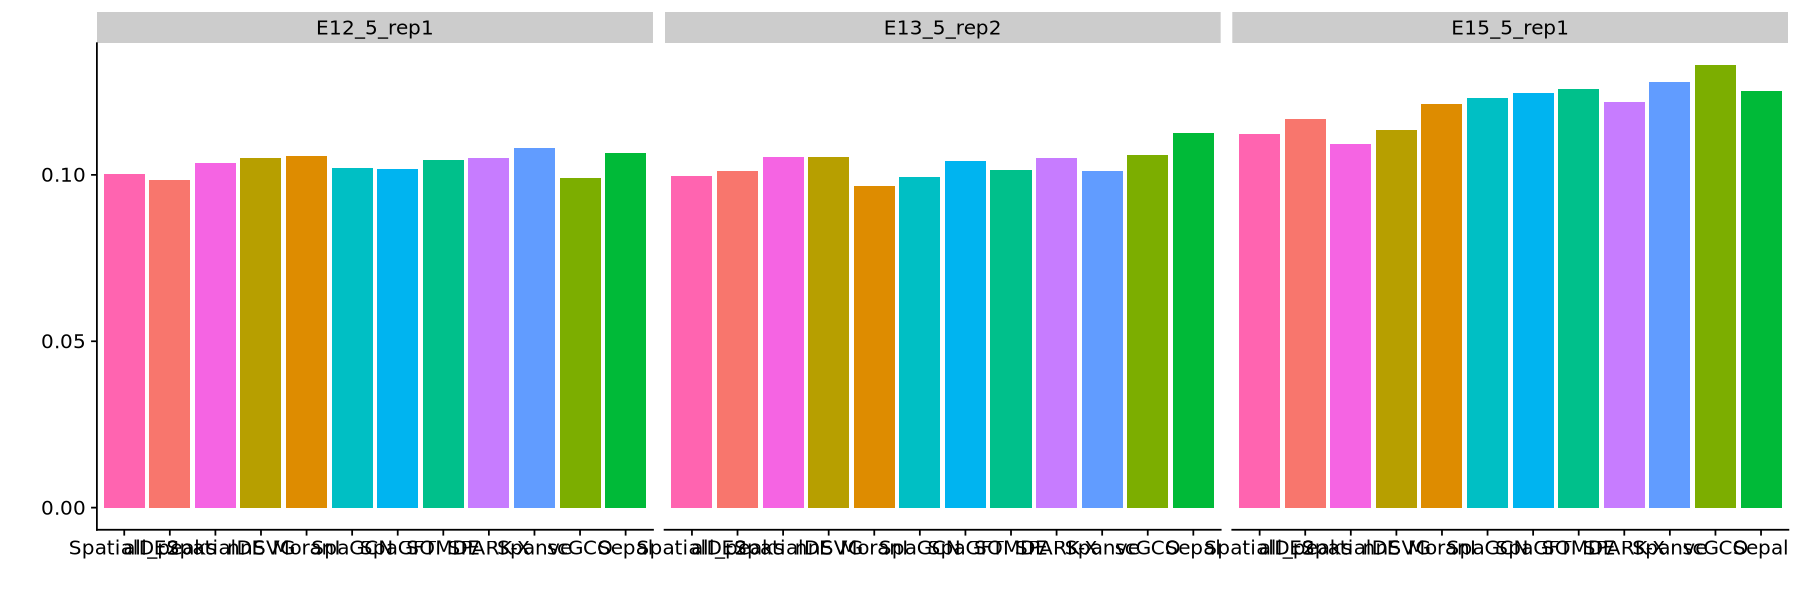

In [6]:
options(repr.plot.height = 5, repr.plot.width = 15)

p <- ggplot(data = df_chaos, aes(x = reorder(method, CHAOS), y = CHAOS)) +
    geom_bar(aes(fill = method), stat='identity') +
    facet_wrap(~dataset) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(legend.position = "none")

p

In [7]:
write.csv(df_chaos, "../../results/09_spatial_atac/05_CHAOS.csv")

#write.csv(df_chaos, "CHAOS.csv")